# Class Activation Mapping with VGG16

In [1]:
#some basic imports and setups
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import io
import os

def grad_cam(img, model, sess, predicted_class, nb_classes):
    print("Setting gradients to 1 for target class and rest to 0")
    # Conv layer tensor [?,7,7,512]
    conv_layer = model.pool5
    # [1000]-D tensor with target class index set to 1 and rest as 0
    one_hot = tf.sparse_to_dense(predicted_class, [nb_classes], 1.0)
    signal = tf.multiply(model.fc_final, one_hot)
    loss = tf.reduce_mean(signal)

    grads = tf.gradients(loss, conv_layer)[0]
    # Normalizing the gradients
    norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads))) + tf.constant(1e-5))

    output, grads_val = sess.run([conv_layer, norm_grads], feed_dict={x: img, keep_prob: 1})
    output = output[0]           # [7,7,512]
    grads_val = grads_val[0]     # [7,7,512]

    weights = np.mean(grads_val, axis = (0, 1)) # [512]
    cam = np.ones(output.shape[0 : 2], dtype = np.float32) # [7,7]

    # Taking a weighted average
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # Passing through ReLU
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (224,224))
    #cam = resize(cam, (224,224))

    # Converting grayscale to 3-D
    cam3 = np.expand_dims(cam, axis=2)
    cam3 = np.tile(cam3,[1,1,3])

    return cam3

#mean of imagenet dataset in BGR
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)

current_dir = os.getcwd()
image_dir = os.path.join(current_dir, 'images')

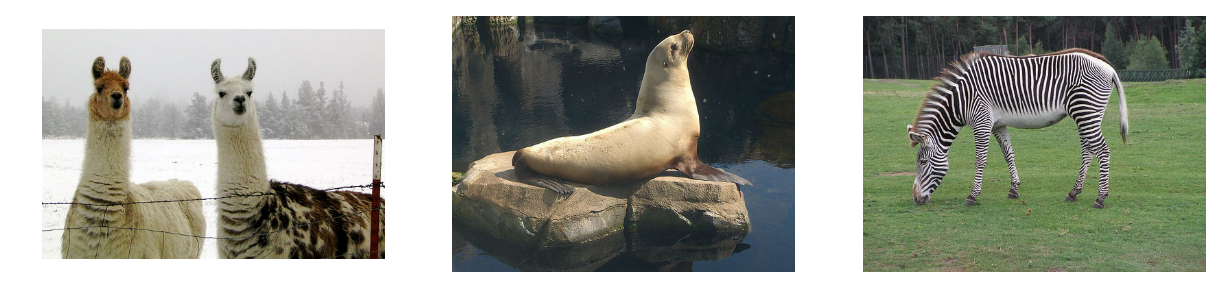

In [2]:
#get list of all images
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpeg')]

#load all images
imgs = []
for f in img_files:
    imgs.append(cv2.imread(f))
    
#plot images
fig = plt.figure(figsize=(15,6))
for i, img in enumerate(imgs):
    fig.add_subplot(1,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [3]:
import sys
sys.path.append('./Network')
sys.path.append('./classes')
from vgg16 import VGG16
from caffe_classes import class_names

#placeholder for input and dropout rate
x = tf.placeholder(tf.float32, [1, 224, 224, 3])
keep_prob = tf.placeholder(tf.float32)

#create model with default config ( == no skip_layer and 1000 units in the last layer)
model = VGG16(x, keep_prob, 1000, [], './Network/pretrained_model/vgg16.npy', name='VGG16')

#define activation of last layer as score
score = model.fc_final

#create op to calculate softmax 
softmax = tf.nn.softmax(score)

Start to load pre-trained model : 
Load Model: |██████████████████████████████████████████████████| 100.0% Complete

Top 5 classes are
llama 0.999993
gazelle 6.30429e-06
hare 8.14709e-07
impala, Aepyceros melampus 1.36721e-08
ibex, Capra ibex 1.31028e-08
Setting gradients to 1 for target class and rest to 0


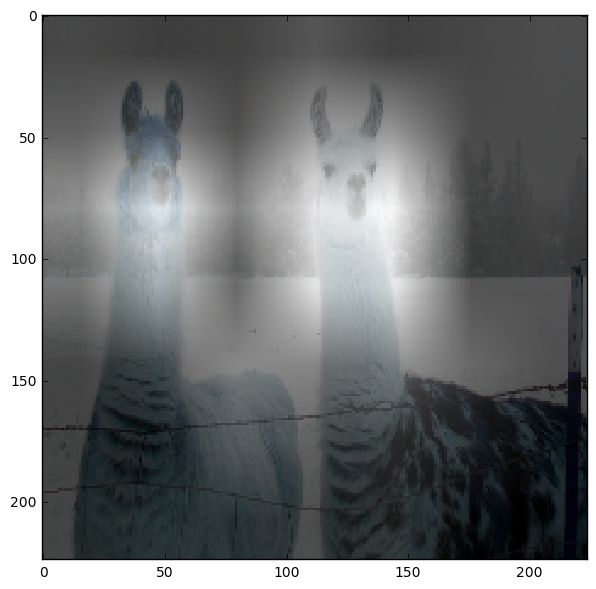


Top 5 classes are
sea lion 0.99655
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus 0.00223003
weasel 0.000978729
otter 0.000218002
mink 1.56801e-05
Setting gradients to 1 for target class and rest to 0


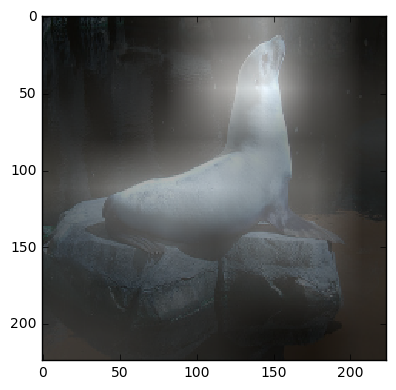


Top 5 classes are
zebra 0.996629
ostrich, Struthio camelus 0.00245271
gazelle 0.000855396
impala, Aepyceros melampus 2.4246e-05
crane 1.34618e-05
Setting gradients to 1 for target class and rest to 0


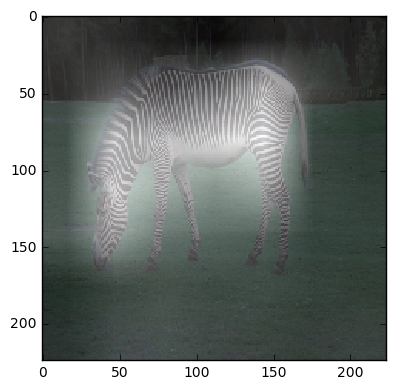

In [4]:
writer = tf.summary.FileWriter('./summary/googlenet')
with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Load the pretrained weights into the model
    model.load_initial_weights(sess)
    
    # Create figure handle
    fig2 = plt.figure(figsize=(15,6))
    
    # Summary write
    writer.add_graph(sess.graph)
    
    # Loop over all images
    for i, image in enumerate(imgs):
        
        # Convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (224,224))
        
        # Subtract the ImageNet mean
        #img -= imagenet_mean
        
        # Reshape as needed to feed into model
        img = img.reshape((1,224,224,3))
        img_forflot = img.reshape((224,224,3))
        
        # Run the session and calculate the class probability
        probs = sess.run(softmax, feed_dict={x: img, keep_prob: 1})
        
        # Get the class name of the class with the highest probability
        class_name = class_names[np.argmax(probs)]
        
        # Feed forwarding
        #preds_list = (np.argsort(probs)[::-1])[0:5]
        preds_list = (np.argsort(probs).flatten()[::-1])[0:5]
        print('\nTop 5 classes are')        
        for p in preds_list:
            print(class_names[p], probs[0, p])
        
        # Target class
        predicted_class = preds_list[0]
        # Number of output classes of model being used
        nb_classes = 1000
        
        cam3 = grad_cam(img, model, sess, predicted_class, nb_classes)
        
        img_float = img_forflot.astype(float)
        img_float /= img_float.max()

        # Superimposing the visualization with the image.
        new_img = img_float+3*cam3
        new_img /= new_img.max()
        
        #print(new_img)        
        
        #img = img.reshape((224, 244, 3))
        
        # Plot image with class name and prob in the title
        #fig2.add_subplot(1,3,i+1)
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        #plt.title("Class: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)])
        #plt.axis('off')
        
        # Display and save
        io.imshow(new_img)
        plt.show()
        #io.imsave('output', new_img)